In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
import math

import tensorflow as tf

#for reproducible results
import random

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.optimizers import dp_optimizer
import tensorflow_privacy

#for logging
import sys
import logging
import datetime


In [2]:
%load_ext tensorboard

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## EDA

In [4]:
data_dir = "/ssd003/projects/pets/datasets/home_credit"
# home_credit_train_df = pd.read_csv(f"{data_dir}/home_credit_train.csv")
# credit_bureau_train_df = pd.read_csv(f"{data_dir}/credit_bureau_train.csv")
data_df = pd.read_csv(f"{data_dir}/train.csv")

In [10]:
len(home_credit_train_df.columns)

99

In [11]:
len(credit_bureau_train_df.columns)

6

In [9]:
len(train_df.columns)

105

In [13]:
len(train_df)

307511

In [38]:
data_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,target
0,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01,1
1,-0.577538,0.426792,1.725450,0.592677,1.600698,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0
2,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0
3,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.024402,-0.022529,-0.018305,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16,0
4,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0


In [16]:
data_df['target'].value_counts()

0    282686
1     24825
Name: target, dtype: int64

In [17]:
24825 / (24825 + 282686)

0.08072881945686496

In [18]:
data_df.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'target'],
      dtype='object', length=105)

In [24]:
types = pd.DataFrame(data_df.dtypes)

In [50]:
types.head(55)

,0
CNT_CHILDREN,float64
AMT_INCOME_TOTAL,float64
AMT_CREDIT,float64
AMT_ANNUITY,float64
AMT_GOODS_PRICE,float64
REGION_POPULATION_RELATIVE,float64
DAYS_BIRTH,float64
DAYS_EMPLOYED,float64
DAYS_REGISTRATION,float64
DAYS_ID_PUBLISH,float64


### Checking for missing data

In [33]:
np.sum(np.sum(data_df.isna()))

0

In [34]:
data_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,target
0,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01,1
1,-0.577538,0.426792,1.725450,0.592677,1.600698,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0
2,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0
3,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.024402,-0.022529,-0.018305,3.336720e-17,0.000000,-3.645032e-17,0.000000,-7.516682e-17,-3.831603e-16,0
4,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,0


In [35]:
data_df.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,target
count,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000
mean,-3.225633e-17,-1.220299e-17,-3.880695e-17,4.621251e-17,6.585514e-16,3.335850e-16,3.350407e-17,4.311627e-17,-6.469751e-18,6.757424e-17,...,-7.625064e-18,-1.940925e-18,6.053839e-18,5.753457e-17,2.768129e-17,-5.857435e-17,1.187661e-17,-1.688490e-17,-3.288482e-16,0.080729
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.272419
min,-5.775378e-01,-6.036870e-01,-1.376496e+00,-1.758940e+00,-1.348293e+00,-1.487798e+00,-2.106335e+00,-5.784940e-01,-5.588007e+00,-2.784328e+00,...,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-1.092866e+00,0.000000
25%,-5.775378e-01,-2.374210e-01,-8.174760e-01,-7.303015e-01,-8.121132e-01,-7.853308e-01,-8.352476e-01,-4.712426e-01,-7.077673e-01,-8.644204e-01,...,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-5.176655e-01,0.000000
50%,-5.775378e-01,-9.129414e-02,-2.124151e-01,-1.521775e-01,-2.393752e-01,-1.459095e-01,6.576450e-02,-4.602923e-01,1.368540e-01,-1.721143e-01,...,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-3.831603e-16,0.000000
75%,8.072731e-01,1.421293e-01,5.208178e-01,5.166083e-01,3.821064e-01,5.635704e-01,8.304332e-01,-4.537519e-01,8.447974e-01,8.441512e-01,...,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,0.000000e+00,-7.516682e-17,6.327349e-01,0.000000
max,2.573387e+01,4.927034e+02,8.574059e+00,1.593252e+01,9.509356e+00,3.733564e+00,1.958761e+00,2.133617e+00,1.415353e+00,1.983641e+00,...,4.098034e+01,4.438721e+01,5.463098e+01,5.121092e+01,8.730290e+01,4.184385e+01,3.137918e+01,3.530567e+02,1.328714e+01,1.000000


(array([2.7649e+05, 3.0466e+04, 5.1300e+02, 2.8000e+01, 4.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.57753784,  2.05360303,  4.6847439 ,  7.31588478,  9.94702565,
        12.57816652, 15.20930739, 17.84044826, 20.47158914, 23.10273001,
        25.73387088]),
 <BarContainer object of 10 artists>)

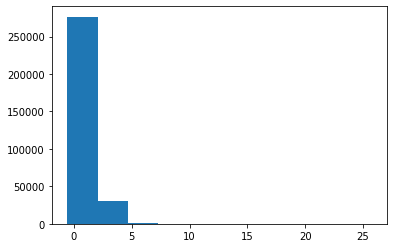

In [36]:
plt.hist(data_df['CNT_CHILDREN'])

(array([3.0751e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -0.35947456,  34.98214314,  70.32376084, 105.66537854,
        141.00699624, 176.34861394, 211.69023164, 247.03184934,
        282.37346704, 317.71508474, 353.05670244]),
 <BarContainer object of 10 artists>)

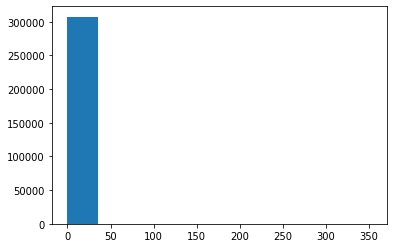

In [41]:
plt.hist(data_df['AMT_REQ_CREDIT_BUREAU_QRT'])

In [43]:
# Check whether there is category data
data_df['FLAG_DOCUMENT_3'].value_counts()

 0.639065    218340
-1.564786     89171
Name: FLAG_DOCUMENT_3, dtype: int64

In [51]:
data_df['ELEVATORS_MODE'].value_counts()

-9.719244e-14    163891
-8.241475e-01     89498
 6.760339e-02     11629
 9.582479e-01      9675
 1.849999e+00      6379
 5.123725e-01      5734
-3.782721e-01      4876
 1.404123e+00      3962
 2.740643e+00      2887
 2.295874e+00      2135
 3.632394e+00      1554
 3.186519e+00      1308
 4.524145e+00      1094
 4.078270e+00       628
 5.414790e+00       491
 6.306541e+00       447
 4.968914e+00       253
 5.860665e+00       226
 7.197185e+00       219
 1.023976e+01       144
 8.088936e+00       137
 6.752416e+00        99
 9.871331e+00        87
 8.980687e+00        66
 7.643061e+00        38
 8.534812e+00        34
 9.425456e+00        20
Name: ELEVATORS_MODE, dtype: int64

### Preparing the dataset to train

In [5]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [6]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the data

In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

### Oversampling

In [8]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train_oversampled, y_oversampled = oversample.fit_resample(train_features, train_labels)

### Define the model metrics

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # underfitting. 
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(40, input_shape=(train_features.shape[-1],), activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(60, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(20, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(80, input_shape=(train_features.shape[-1],), activation='relu'),
#         tf.keras.layers.Dropout(0.4),
#         tf.keras.layers.Dense(80, activation='relu'),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Dense(40, activation='relu'),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [10]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048
# BATCH_SIZE = 250

early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
    monitor="val_auc",
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Check training history

In [12]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

### Evaluate metrics
You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label. 

In [13]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

### ROC

In [14]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

### AUPRC

In [15]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [16]:
resampled_features = X_train_oversampled
resampled_labels = y_oversampled

### Vanilla non-DP model

In [85]:
# resampled_model = make_model()
# resampled_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=METRICS)

# # Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])
# # resampled_steps_per_epoch = 20

# resampled_history = resampled_model.fit(
#     resampled_features, resampled_labels,
#     epochs=EPOCHS,
# #     steps_per_epoch=resampled_steps_per_epoch,
#     callbacks=[early_stopping],
#     validation_data=(val_features, val_labels))

Epoch 1/100
 1034/14134 [=>............................] - ETA: 1:01 - loss: 0.6597 - tp: 10690.0000 - fp: 6643.0000 - tn: 9886.0000 - fn: 5869.0000 - accuracy: 0.6219 - precision: 0.6167 - recall: 0.6456 - auc: 0.6647 - prc: 0.6280

KeyboardInterrupt: 

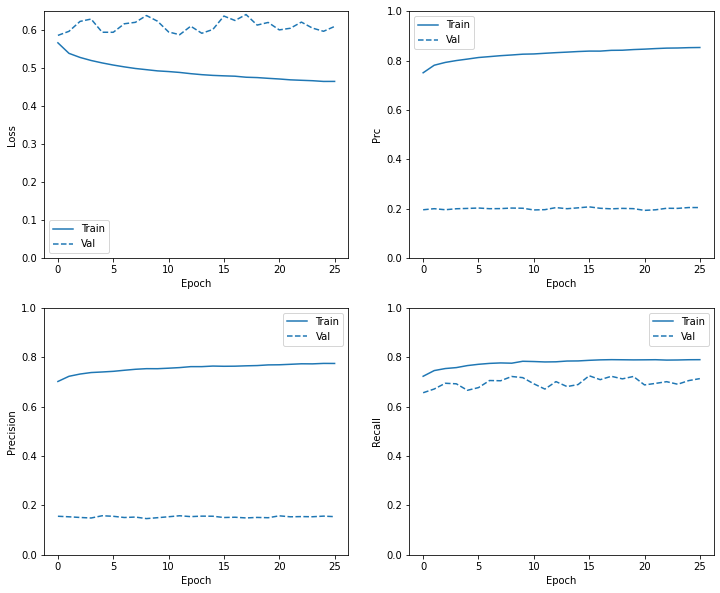

In [81]:
# plot_metrics(resampled_history)

In [45]:
# resampled_model = make_model()
# resampled_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=METRICS)

# # Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])

# resampled_history = resampled_model.fit(
#     resampled_features, resampled_labels,
#     # These are not real epochs
#     steps_per_epoch=20,
#     epochs=10*EPOCHS,
#     callbacks=[early_stopping],
#     validation_data=(val_features, val_labels))

Epoch 1/1000
20/20 [==============================] - 10s 444ms/step - loss: 0.6925 - tp: 105890.0000 - fp: 102409.0000 - tn: 180277.0000 - fn: 125191.0000 - accuracy: 0.5570 - precision: 0.5084 - recall: 0.4582 - auc: 0.5834 - prc: 0.4872 - val_loss: 0.6270 - val_tp: 2749.0000 - val_fp: 16484.0000 - val_tn: 40070.0000 - val_fn: 2200.0000 - val_accuracy: 0.6962 - val_precision: 0.1429 - val_recall: 0.5555 - val_auc: 0.6774 - val_prc: 0.1610
Epoch 2/1000
20/20 [==============================] - 7s 354ms/step - loss: 0.6567 - tp: 129299.0000 - fp: 78773.0000 - tn: 147359.0000 - fn: 96833.0000 - accuracy: 0.6117 - precision: 0.6214 - recall: 0.5718 - auc: 0.6564 - prc: 0.6306 - val_loss: 0.6132 - val_tp: 3115.0000 - val_fp: 18612.0000 - val_tn: 37942.0000 - val_fn: 1834.0000 - val_accuracy: 0.6676 - val_precision: 0.1434 - val_recall: 0.6294 - val_auc: 0.7032 - val_prc: 0.1811
Epoch 3/1000
20/20 [==============================] - 7s 352ms/step - loss: 0.6337 - tp: 143343.0000 - fp: 76292.

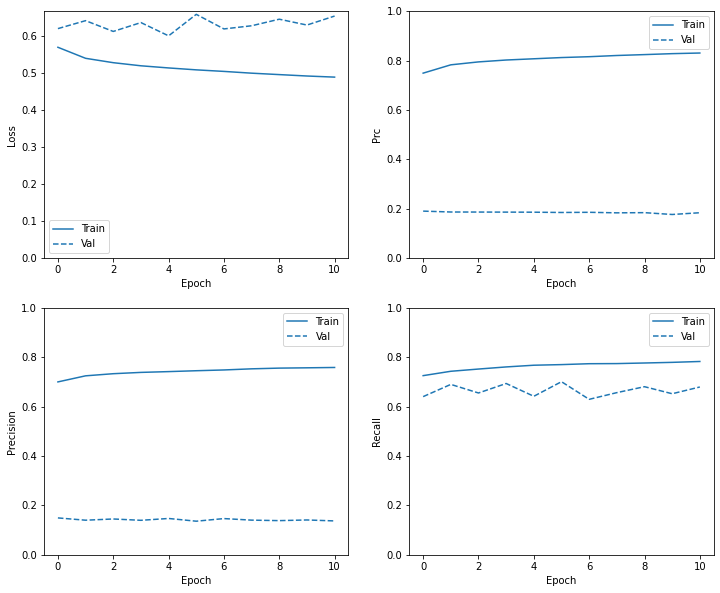

In [61]:
# plot_metrics(resampled_history)

### Performance

In [82]:
# train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
# test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [17]:
def evaluate_models(keras_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE):
    train_predictions = keras_model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = keras_model.predict(test_features, batch_size=BATCH_SIZE)
    test_prediction_results = keras_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(keras_model.metrics_names, test_prediction_results):
        print(name, ": ", value)
    print()
    plot_cm(test_labels, test_predictions)
    print()
    print("Plot ROC")
    plot_roc("Train Resampled", train_labels, train_predictions, color=colors[2])
    plot_roc("Test Resampled", test_labels, test_predictions, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.title("ROC")
    plt.show()
    
    print()
    print("Plot Precision-Recall Curve")
    plot_prc("Train Resampled", train_labels, train_predictions, color=colors[2])
    plot_prc("Test Resampled", test_labels, test_predictions, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.title("Precision Recall Curve")
    plt.show()
    

loss :  0.5734538435935974
tp :  3308.0
fp :  18914.0
tn :  37640.0
fn :  1641.0
accuracy :  0.6657886505126953
precision :  0.14886148273944855
recall :  0.6684178709983826
auc :  0.7321951389312744
prc :  0.210875004529953

Legitimate Transactions Detected (True Negatives):  37640
Legitimate Transactions Incorrectly Detected (False Positives):  18914
Fraudulent Transactions Missed (False Negatives):  1641
Fraudulent Transactions Detected (True Positives):  3308
Total Fraudulent Transactions:  4949


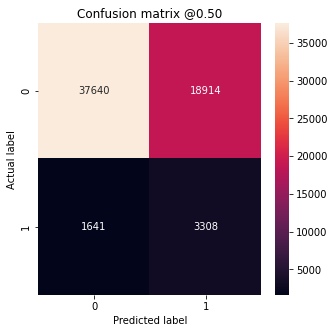

In [76]:
# resampled_results = resampled_model.evaluate(test_features, test_labels,
#                                              batch_size=BATCH_SIZE, verbose=0)
# for name, value in zip(resampled_model.metrics_names, resampled_results):
#     print(name, ': ', value)
# print()

# plot_cm(test_labels, test_predictions_resampled)

#### ROC

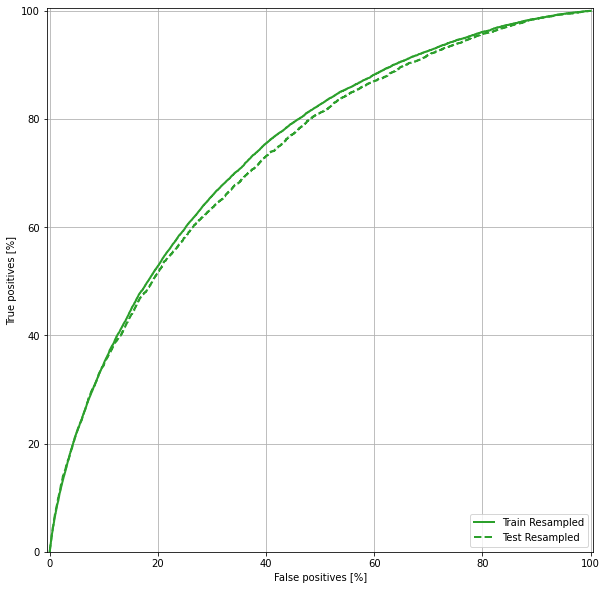

In [77]:
# plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
# plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
# # plt.legend(loc='lower right')

### Plot the AUPRC

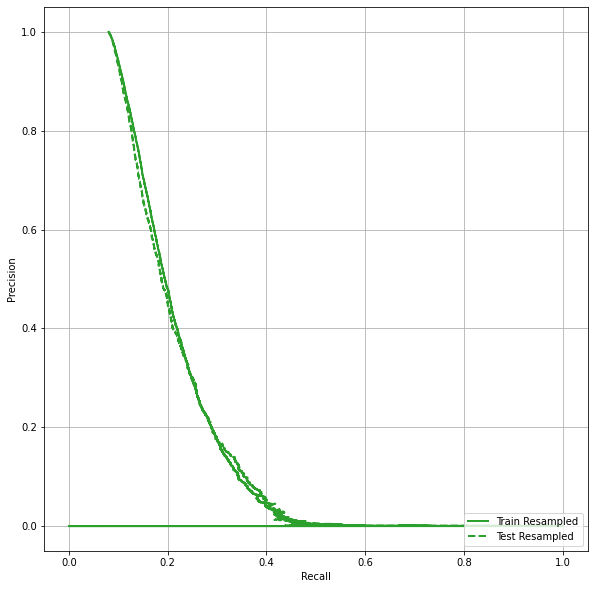

In [78]:
# plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
# plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
# plt.legend(loc='lower right')

## DP-SGD

In [18]:
def compute_epsilon(steps, training_size, noise_multiplier, batch_size):
    """Computes epsilon value for given hyperparameters."""
    if noise_multiplier == 0.0:
        return float('inf')

    #rule of thumb for delta is to set it to less than the inverse of the training data size
    #so I opted for it to equal to 1.1*training size
    training_delta = 1 / (training_size *1.1) 

    orders = np.linspace(1+math.log(1./training_delta)/10, 1+math.log(1./training_delta)/1, num=100)
    #if you want epsilon between 1-10 and your delta is fixed
    # your orders must cover the range between 1+ln(1/delta)/10 and 1+ln(1/delta)/1

    sampling_probability = batch_size / training_size
    rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)

    return get_privacy_spent(orders, rdp, target_delta=training_delta)[0], training_delta

In [19]:
def train(dpsgd, batch_size, microbatches, l2_norm_clip, noise_multiplier, learning_rate, epochs, 
          resampled_features, resampled_labels, print_output = True, verbose = 0):
    #logging.set_verbosity(logging.INFO)
    if dpsgd and batch_size % microbatches != 0:
        raise ValueError('Number of microbatches should divide evenly batch_size')

    # Define a sequential Keras model
    resampled_dp_model = make_model()

    # Reset the bias to zero, since this dataset is balanced.
    #output_layer = resampled_dp_model.layers[-1] 
    #output_layer.bias.assign([0])

    if dpsgd:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=microbatches,
            learning_rate=learning_rate)
        # Compute vector of per-example loss rather than its mean over a minibatch.
        loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss = tf.keras.losses.BinaryCrossentropy()

    # Compile model with Keras
    resampled_dp_model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    training_size = resampled_features.shape[0]

    # Train model with Keras
    resampled_dp_history = resampled_dp_model.fit(
        resampled_features, resampled_labels,
        epochs=epochs,
#         steps_per_epoch=resampled_steps_per_epoch,
        callbacks=[early_stopping, tensorboard_callback], #monitor='val_prc', higher = better
        validation_data=(val_features, val_labels),
        verbose = verbose)
    
    score_train = resampled_dp_model.evaluate(resampled_features, resampled_labels, verbose=verbose)
    score_val = resampled_dp_model.evaluate(val_features, val_labels, verbose=verbose)
    score_test = resampled_dp_model.evaluate(test_features, test_labels, verbose=verbose)

    weights = resampled_dp_model.get_weights()

    # Compute the privacy budget expended.
    if dpsgd:
        eps, delta = compute_epsilon(epochs * training_size // batch_size, training_size=training_size, 
                                     noise_multiplier=noise_multiplier, batch_size=batch_size)
        if print_output:
            print('For delta=%.4f, the current epsilon is: %.2f' % (delta, eps))
    else:
        if print_output:
            print('Trained with vanilla non-private SGD optimizer')

    if print_output:
        print("Training Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_train):
            print(name, ': ', value)
        print()
        print("Validation Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_val):
            print(name, ': ', value)
        print()
        print("Testing Result")
        for name, value in zip(resampled_dp_model.metrics_names, score_test):
            print(name, ': ', value)
        print()     

    if dpsgd:
        return resampled_dp_model, score_train, score_val, score_test, eps, delta, weights, resampled_dp_history
    
    return resampled_dp_model, score_train, score_val, score_test, weights, resampled_dp_history 

### DP-SGD model

In [21]:
from time import time

In [22]:
tic = time()
resampled_dp_model, score_train, score_val, score_test, eps, delta, weights, resampled_dp_history = train(dpsgd=True, batch_size=BATCH_SIZE, microbatches=1, l2_norm_clip=1.0, 
      noise_multiplier=1.0, learning_rate=0.001, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 1)
toc = time()
print("Time used to train dp-sgd model: {}", toc - tic)

Epoch 1/100
11311/11311 [==============================] - 76s 6ms/step - loss: 0.7741 - tp: 75708.0000 - fp: 49590.0000 - tn: 131382.0000 - fn: 105264.0000 - accuracy: 0.5722 - precision: 0.6042 - recall: 0.4183 - auc: 0.6079 - prc: 0.5897 - val_loss: 0.5814 - val_tp: 2203.0000 - val_fp: 12437.0000 - val_tn: 32723.0000 - val_fn: 1839.0000 - val_accuracy: 0.7098 - val_precision: 0.1505 - val_recall: 0.5450 - val_auc: 0.6895 - val_prc: 0.1693
Epoch 2/100
11311/11311 [==============================] - 71s 6ms/step - loss: 0.6661 - tp: 89579.0000 - fp: 50671.0000 - tn: 130301.0000 - fn: 91393.0000 - accuracy: 0.6075 - precision: 0.6387 - recall: 0.4950 - auc: 0.6578 - prc: 0.6347 - val_loss: 0.6030 - val_tp: 2392.0000 - val_fp: 13070.0000 - val_tn: 32090.0000 - val_fn: 1650.0000 - val_accuracy: 0.7008 - val_precision: 0.1547 - val_recall: 0.5918 - val_auc: 0.7008 - val_prc: 0.1787
Epoch 3/100
11311/11311 [==============================] - 71s 6ms/step - loss: 0.6526 - tp: 98324.0000 - fp:

loss :  0.611685574054718
tp :  3017.0
fp :  17514.0
tn :  39040.0
fn :  1932.0
accuracy :  0.6838203072547913
precision :  0.14694851636886597
recall :  0.6096181273460388
auc :  0.7030707001686096
prc :  0.1813870668411255



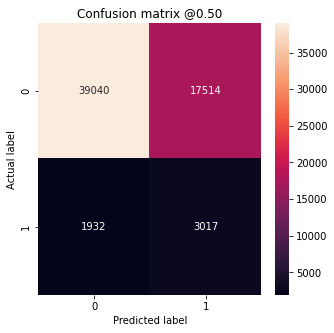

Legitimate Transactions Detected (True Negatives):  39040
Legitimate Transactions Incorrectly Detected (False Positives):  17514
Fraudulent Transactions Missed (False Negatives):  1932
Fraudulent Transactions Detected (True Positives):  3017
Total Fraudulent Transactions:  4949

Plot ROC


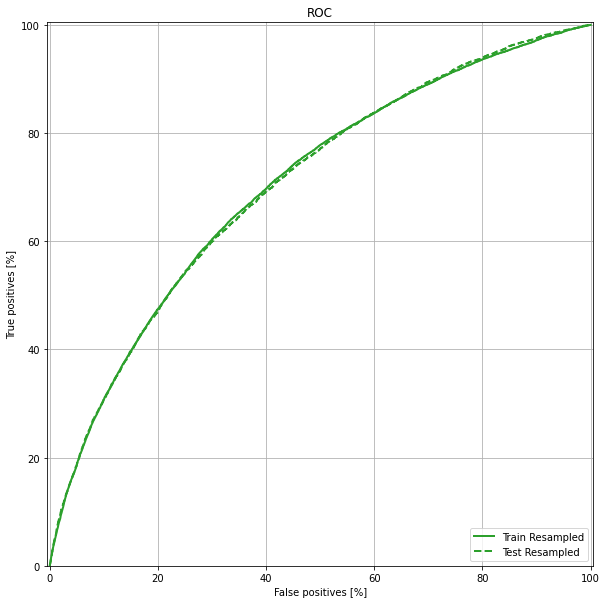


Plot Precision-Recall Curve


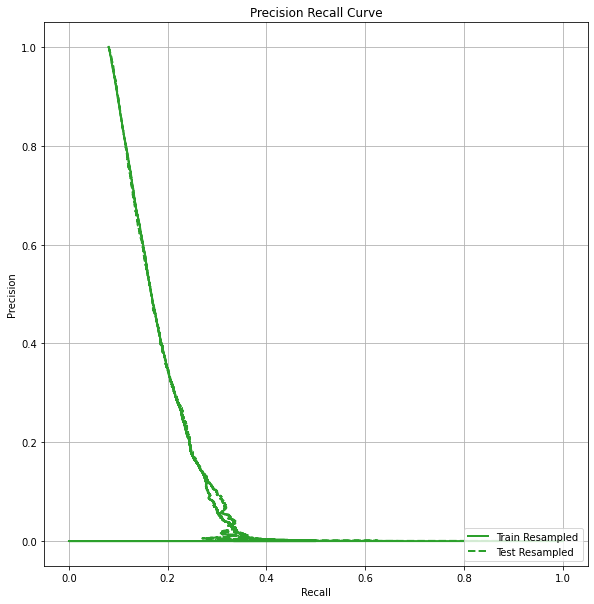

In [31]:
evaluate_models(resampled_dp_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE)

In [94]:
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### non-DP Model

In [32]:
tic = time()
resampled_model, score_train, score_val, score_test, weights, resampled_history = train(dpsgd=False, batch_size=BATCH_SIZE, microbatches=1, l2_norm_clip=1.0, 
      noise_multiplier=1.0, learning_rate=0.001, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 1)
toc = time()
print("Time to train non-dp model; ", toc - tic)

Epoch 1/100
11311/11311 [==============================] - 61s 5ms/step - loss: 0.6054 - tp: 130780.0000 - fp: 80129.0000 - tn: 157397.0000 - fn: 55141.0000 - accuracy: 0.6806 - precision: 0.6201 - recall: 0.7034 - auc: 0.7389 - prc: 0.6656 - val_loss: 0.5857 - val_tp: 2697.0000 - val_fp: 15080.0000 - val_tn: 30080.0000 - val_fn: 1345.0000 - val_accuracy: 0.6662 - val_precision: 0.1517 - val_recall: 0.6672 - val_auc: 0.7248 - val_prc: 0.1991
Epoch 2/100
11311/11311 [==============================] - 58s 5ms/step - loss: 0.5950 - tp: 132763.0000 - fp: 63490.0000 - tn: 117482.0000 - fn: 48209.0000 - accuracy: 0.6914 - precision: 0.6765 - recall: 0.7336 - auc: 0.7483 - prc: 0.7142 - val_loss: 0.5630 - val_tp: 2601.0000 - val_fp: 14077.0000 - val_tn: 31083.0000 - val_fn: 1441.0000 - val_accuracy: 0.6846 - val_precision: 0.1560 - val_recall: 0.6435 - val_auc: 0.7237 - val_prc: 0.2012
Epoch 3/100
11311/11311 [==============================] - 58s 5ms/step - loss: 0.5923 - tp: 133400.0000 - f

loss :  0.5989236831665039
tp :  3353.0
fp :  18939.0
tn :  37615.0
fn :  1596.0
accuracy :  0.6661138534545898
precision :  0.15041270852088928
recall :  0.6775106191635132
auc :  0.7343159914016724
prc :  0.20872680842876434



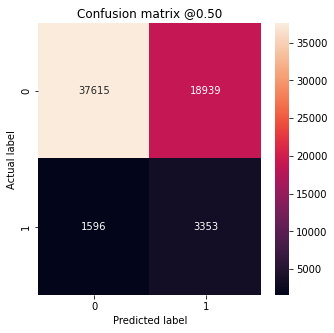

Legitimate Transactions Detected (True Negatives):  37615
Legitimate Transactions Incorrectly Detected (False Positives):  18939
Fraudulent Transactions Missed (False Negatives):  1596
Fraudulent Transactions Detected (True Positives):  3353
Total Fraudulent Transactions:  4949

Plot ROC


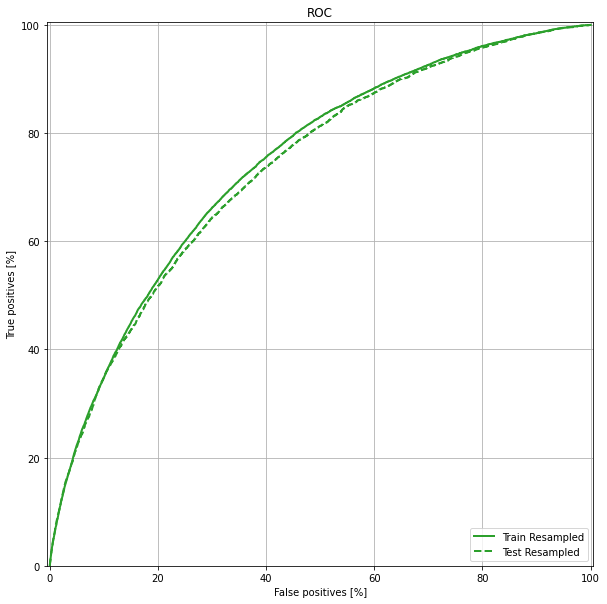


Plot Precision-Recall Curve


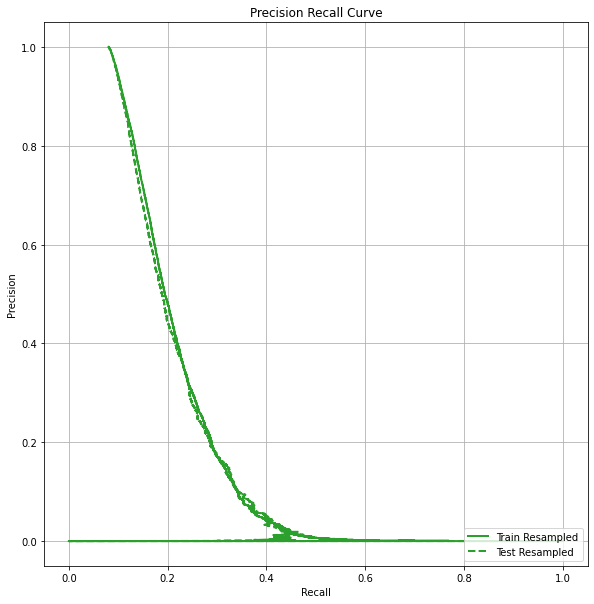

In [33]:
evaluate_models(resampled_model, train_features, train_labels, test_features, test_labels, BATCH_SIZE)

In [ ]:
%tensorboard --logdir logs/fit

## Hyperparameter tuning to reduce epsilon 


Two metrics are used to express the DP guarantee of an ML algorithm:

1.   Delta ($\delta$) - Bounds the probability of the privacy guarantee not holding. A rule of thumb is to set it to be less than the inverse of the size of the training dataset. In this tuturial, delta is set to a fixed value.
2.   Epsilon ($\epsilon$) - Measures the strength of the privacy guarantee by bounding how much the probability of a particular model output can vary by including (or excluding) a single training point. A smaller value for $\epsilon$ implies a better privacy guarantee. However, the $\epsilon$ value is only an upper bound and a large value could still mean good practical privacy.

Note:

* smaller epsilon = better

* ε=0 (and δ=0 in the general case) is equivalent to absolute privacy.

### Hyperparameters that need to be tuned for DP-SGD:
+ **l2_norm_clip** (float)
* **noise_multiplier** (float)
* **microbatches** (int)
* **learning_rate** (float)


In [20]:
def train_hp_tuning(dpsgd, batch_sizes, microbatches_list, l2_norm_clips, 
                    noise_multipliers, learning_rate, epochs,  model_dir=None, print_output = False, verbose = 0):
    
    table_outputs = []
    for batch_size in batch_sizes:
        for microbatches in microbatches_list:
            for l2_norm_clip in l2_norm_clips:
                for noise_multiplier in noise_multipliers:

                    _, score_train, score_val, score_test, eps, delta, _, _ = train(dpsgd=dpsgd, 
                                        batch_size=batch_size, microbatches=microbatches, l2_norm_clip=l2_norm_clip,
                                        noise_multiplier=noise_multiplier, learning_rate=learning_rate, 
                                        epochs=epochs, resampled_features=resampled_features, resampled_labels=resampled_labels,
                                        print_output=print_output, verbose = verbose)
                    
                    table_outputs.append([learning_rate, noise_multiplier, l2_norm_clip, epochs, batch_size, microbatches,
                                        score_train[0], score_train[6],  score_train[7],  score_train[8], score_train[9], 
                                        score_val[0],  score_val[6],  score_val[7],  score_val[8],  score_val[9], 
                                        score_test[0], score_test[6], score_test[7], score_test[8], score_test[9], 
                                        eps, delta])

                
    df = pd.DataFrame(table_outputs, columns=['learning rate', 'noise multiplier', 'L2 norm clip',
                                                'Epochs', 'Batch size', 'Microbatches', 
                                              'Training loss', 'Training precision', 'Training recall', 'Training AUC', 'Training PRC', 
                                              'Validation loss', 'Validation precision', 'Validation recall', 'Validation AUC', 'Validation PRC', 
                                              'Test loss', 'Test precision', 'Test recall', 'Test AUC', 'Test PRC', 
                                              'Epsilon', 'Delta'])

    return df

In [35]:
noise_multipliers = [1, 3, 5]
l2_norm_clips = [0.9, 1.0, 1.1]
# batch_sizes = [1024, 2048]
batch_sizes = [1024]
microbatches_list = [1]

training_outputs = train_hp_tuning(dpsgd=True,  batch_sizes = batch_sizes,
                                   microbatches_list=microbatches_list,
                                   l2_norm_clips=l2_norm_clips, 
                                   noise_multipliers=noise_multipliers, 
                                    learning_rate=0.0005, epochs=100,  model_dir=None,
                                    print_output = False, verbose = 0)




Restoring model weights from the end of the best epoch: 13.
Epoch 00023: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 00018: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 00015: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 00020: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 00035: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 00020: early stopping
Restoring model weights from the end of the best epoch: 21.
Epoch 00031: early stopping


In [36]:
training_outputs.sort_values(by=['Validation PRC', 'Epsilon'], ascending=[False, True])
training_outputs

,learning rate,noise multiplier,L2 norm clip,Epochs,Batch size,Microbatches,Training loss,Training precision,Training recall,Training AUC,...,Validation recall,Validation AUC,Validation PRC,Test loss,Test precision,Test recall,Test AUC,Test PRC,Epsilon,Delta
0,0.0005,1,0.9,100,1024,1,0.604704,0.672550,0.696754,0.740996,...,0.659574,0.713486,0.190323,0.606288,0.145888,0.667003,0.719701,0.194424,3.435756,0.000003
1,0.0005,3,0.9,100,1024,1,0.637954,0.617741,0.723897,0.691265,...,0.674419,0.656228,0.143586,0.657070,0.117731,0.683168,0.660854,0.146235,0.953165,0.000003
2,0.0005,5,0.9,100,1024,1,0.675512,0.632658,0.534773,0.660462,...,0.486640,0.630175,0.124378,0.566635,0.123985,0.505759,0.633457,0.122278,0.801555,0.000003
3,0.0005,1,1.0,100,1024,1,0.626626,0.678165,0.621367,0.722206,...,0.602919,0.705139,0.183012,0.628356,0.153059,0.610628,0.712424,0.189217,3.435756,0.000003
4,0.0005,3,1.0,100,1024,1,0.645161,0.669938,0.543222,0.693767,...,0.482682,0.653656,0.142427,0.547253,0.140183,0.499293,0.662959,0.144001,0.953165,0.000003
5,0.0005,5,1.0,100,1024,1,0.699474,0.604439,0.438095,0.616971,...,0.440623,0.610569,0.116177,0.583986,0.118153,0.444130,0.613934,0.116649,0.801555,0.000003
6,0.0005,1,1.1,100,1024,1,0.605487,0.668351,0.715542,0.741637,...,0.664028,0.711092,0.184734,0.599030,0.142863,0.676702,0.719600,0.191331,3.435756,0.000003
7,0.0005,3,1.1,100,1024,1,0.658510,0.679845,0.407726,0.679191,...,0.357249,0.641908,0.134453,0.535764,0.141669,0.361285,0.645488,0.133413,0.953165,0.000003
8,0.0005,5,1.1,100,1024,1,0.766390,0.586176,0.663456,0.634812,...,0.662791,0.631792,0.132562,0.910391,0.109407,0.654476,0.631158,0.134677,0.801555,0.000003


In [37]:
training_outputs.to_csv("training_outputs.csv", index=False)

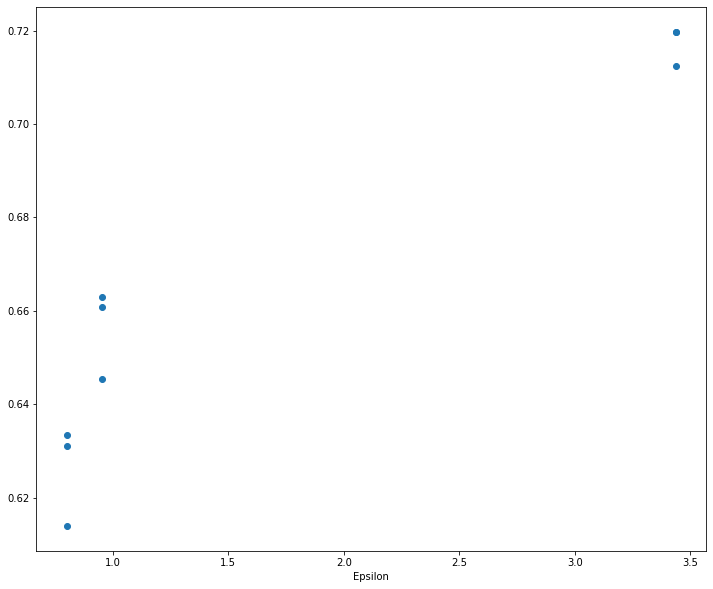

In [20]:
training_outputs = pd.read_csv("training_outputs.csv")
plt.scatter(training_outputs['Epsilon'], training_outputs['Test AUC'])
plt.xlabel("Epsilon")
plt.show("Test AUC")

Best prameter for lower privacy but higher accuracy
Epsilon = 3.43  The best AUC = 0.7197
    learning_rate = 0.0005, noise_multiplier = 1, L2_clip=0.9, epochs = 100, batch_size = 1024

Best prameter for higher privacy but lower accuracy
Epsilon = 0.95.  The best AUC = 0.6629
    learning_rate = 0.0005, noise_multiplier = 3, L2_clip=1, epochs = 100, batch_size = 1024

In [26]:
high_privacy_param = {'learning_rate' : 0.0005,
                     'noise_multiplier' :1,
                     'L2_clip' :0.9,
                     'batch_size' :1024}
low_privacy_param = {'learning_rate':0.0005,
                     'noise_multiplier':3,
                     'L2_clip':1,
                     'batch_size':1024}

## Adversarial Test

Randomly pick 10 samples from the train_df.  Remove each of them to generate a new non-DP model and DP model.  Compare the performance of the non-DP model and DP model on how the sample will be identified.

In [39]:
def adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, privacy_param):
#     # Remove the sample from training data
#     new_train_df = train_df.drop(index=sample_index_to_remove, axis=0)
    
#     train_labels = np.array(new_train_df.pop('target'))
#     train_features = np.array(new_train_df)
    
#     # Oversampling
#     resampled_features, resampled_labels = oversample.fit_resample(train_features, train_labels)
    
    # Remove the sample from training data
    resampled_features = resampled_features.drop(index=sample_index_to_remove, axis=0)
    resampled_labels = resampled_labels.drop(index=sample_index_to_remove, axis=0)
    
    learning_rate = privacy_param['learning_rate']
    noise_multiplier = privacy_param['noise_multiplier']
    L2_clip = privacy_param['L2_clip']
    batch_size = privacy_param['batch_size']
    
    non_dp_model, score_train, score_val, score_test, non_dp_weights, resampled_history = train(dpsgd=False, batch_size=batch_size, microbatches=1, l2_norm_clip=L2_clip, 
      noise_multiplier=noise_multiplier, learning_rate=learning_rate, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 0)
    
    dp_model, score_train, score_val, score_test, eps, delta, dp_weights, resampled_dp_history = train(dpsgd=True, batch_size=batch_size, microbatches=1, l2_norm_clip=L2_clip, 
      noise_multiplier=noise_multiplier, learning_rate=learning_rate, epochs=EPOCHS, 
      resampled_features=resampled_features, resampled_labels=resampled_labels,print_output=True, verbose = 0)
    
    return non_dp_model, non_dp_weights, dp_model, dp_weights

In [40]:
def compute_weight_diff(non_dp_weights, dp_weights):
    #compute difference between model parameters
    diffs = []
    sums = []

    #obtain the pairwise difference between the two models by enumrating through each set of weights and biases
    for index, value in enumerate(non_dp_weights):
        diffs.append(np.abs(non_dp_weights[index] - dp_weights[index]))
        sums.append(np.sum(np.abs(non_dp_weights[index]) + np.abs(dp_weights[index])))

    overall_sum_model_weights = np.sum(sums)

    #flatten the list of diffs between model parameters into one long list
    diffs_flattened = np.concatenate([x.ravel() for x in diffs])

    #normalize each element in the flattened list by dividing by the overall sum of model weights
    diffs_flattened_normalized = diffs_flattened / overall_sum_model_weights

    #print(np.sum(diffs), np.sum(sums))
    #print(np.sum(np.divide(diffs,sums)), np.divide(np.sum(diffs), np.sum(sums)))

    normalized_mean_diff_dpsgd = np.mean(diffs_flattened_normalized)

#     print("the normalized mean difference between model weights trained with DP-SGD is: ", normalized_mean_diff_dpsgd)
    return normalized_mean_diff_dpsgd
    

In [ ]:
# train_df = train_df.reset_index(drop=True)
# data_size = len(train_df)
resampled_features = pd.DataFrame(resampled_features)
resampled_labels = pd.DataFrame(resampled_labels)
data_size = len(resampled_features)

random.seed(1)
sample_size = 10

removed_index_list = []
# high privacy
hp_weight_diff_list = []
# low privacy
lp_weight_diff_list = []

for i in range(sample_size):
    sample_index_to_remove = random.randint(0, data_size)
    removed_index_list.append(sample_index_to_remove)
    print("Remove index: {}".format(sample_index_to_remove))
    # adversarial test on high privacy parameter models
    non_dp_model_hp, non_dp_weights_hp, dp_model_hp, dp_weights_hp = adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, high_privacy_param)
    weight_diff_hp = compute_weight_diff(non_dp_weights_hp, dp_weights_hp)
    hp_weight_diff_list.append(weight_diff_hp)
    print("Weight difference for High privacy: {}".format(weight_diff_hp))
    # adversarial test on low privacy parameter models
    non_dp_model_lp, non_dp_weights_lp, dp_model_lp, dp_weights_lp = adversarial_test(resampled_features, resampled_labels, sample_index_to_remove, low_privacy_param)
    weight_diff_lp = compute_weight_diff(non_dp_weights_lp, dp_weights_lp)
    lp_weight_diff_list.append(weight_diff_lp)
    print("Weight difference for Low privacy: {}".format(weight_diff_lp))
    
adversarial_test_result = pd.DataFrame()
adversarial_test_result['removed index'] = removed_index_list
adversarial_test_result['weight_diff_high_privacy'] = hp_weight_diff_list
adversarial_test_result['weight_diff_low_privacy'] = lp_weight_diff_list

adversarial_test_result
    


Remove index: 70445
Restoring model weights from the end of the best epoch: 21.
Epoch 00031: early stopping
Trained with vanilla non-private SGD optimizer
Training Result
loss :  0.5491588711738586
tp :  141542.0
fp :  58923.0
tn :  122048.0
fn :  39430.0
accuracy :  0.7282638549804688
precision :  0.7060683965682983
recall :  0.7821210026741028
auc :  0.796397864818573
prc :  0.7620633840560913

Validation Result
loss :  0.5695942640304565
tp :  2664.0
fp :  14743.0
tn :  30417.0
fn :  1378.0
accuracy :  0.6723507046699524
precision :  0.15304188430309296
recall :  0.6590796709060669
auc :  0.7269066572189331
prc :  0.20670881867408752

Testing Result
loss :  0.56843501329422
tp :  3322.0
fp :  18670.0
tn :  37884.0
fn :  1627.0
accuracy :  0.6699835658073425
precision :  0.15105493366718292
recall :  0.6712467074394226
auc :  0.7343898415565491
prc :  0.21241062879562378

Restoring model weights from the end of the best epoch: 29.
Epoch 00039: early stopping
For delta=0.0000, the cur

In [ ]:
adversarial_test_result.to_csv("adversarial_test_result.csv", index=False)